# Stress Classification from Speech Data with OpenSMILE Features

In [1]:
import glob
import os
import subprocess
import numpy as np
import pandas as pd
from scipy.io import arff
from io import StringIO
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from joblib import dump, load
from sklearn.svm import SVC
from sklearn.feature_selection import f_classif
from joblib import dump, load

In [2]:
DATA_PATH = "/home/moeflon/OneDrive/VOP/Voice and App/"
OPENSMILE_CONFIG = "/opt/opensmile/config/emobase.conf"
FEATURES_PATH = DATA_PATH + "features_emobase/"
STRESSED_PATH = FEATURES_PATH + "stressed/"
STRESSED_FREEFORM_PATH = FEATURES_PATH + "stressed_freeform/"
UNSTRESSED_PATH = FEATURES_PATH + "unstressed/"

# Extracting features

In [3]:
def extract(source, destination):
    p = subprocess.Popen("SMILExtract -C {} -I {} -O {}".format(OPENSMILE_CONFIG, source, destination), stdout=subprocess.PIPE, shell=True)
    p.wait()

for wav_file in glob.glob(DATA_PATH + "*/*.wav"):
    participant_dir = "/".join(wav_file.split("/")[:-1])
    name = os.path.basename(wav_file).split(".")[0]
    
    if name == "stressed":
        path = STRESSED_PATH
    elif name == "unstressed":
        path = UNSTRESSED_PATH
    elif name == "stressed_freeform":
        path = STRESSED_FREEFORM_PATH
        
    out_path = path + name + "_" + participant_dir + ".arff"
    extract(wav_file, out_path)

# Load in data

In [3]:
label_file = '' # If this is a path to a csv containing labels, these labels will be used instead of pre/post
subset_ids = [] # If this contains ids, only use these ids in the dataset

stressed_datas = []
stressed_ff_datas = []
unstressed_datas = []

for stressed_file in glob.glob(STRESSED_FREEFORM_PATH + "*.arff"):
    did = os.path.basename(stressed_file).split('_')[-1].split('.')[0]
    if len(subset_ids) > 0 and did not in subset_ids:
        continue
    arff_content = open(stressed_file, "r").read()
    
    # scipy ARFF implementation doesn't support non-numeric attributes so remove them (aren't informative anyways)...
    arff_content = arff_content.replace("'noname',", "").replace("@attribute name string", "").replace("'liveturn_0',", "").replace(",unassigned", "").replace("@attribute class numeric", "").replace("@attribute emotion unknown", "").replace(",?", "").replace("'unknown',", "")
    f = StringIO(arff_content)
    data = arff.loadarff(f)
    data = pd.DataFrame(data[0])
    data["id"] = did
    data["file"] = os.path.basename(stressed_file)
    if data.shape[0] > 1:
        data.drop(data.index[1], inplace=True)
    stressed_ff_datas.append(data)

for stressed_file in glob.glob(STRESSED_PATH + "*.arff"):
    did = os.path.basename(stressed_file).split('_')[1].split('.')[0]
    if len(subset_ids) > 0 and did not in subset_ids:
        continue
    arff_content = open(stressed_file, "r").read()
    arff_content = arff_content.replace("'noname',", "").replace("@attribute name string", "").replace("'liveturn_0',", "").replace(",unassigned", "").replace("@attribute class numeric", "").replace("@attribute emotion unknown", "").replace(",?", "").replace("'unknown',", "")
    f = StringIO(arff_content)
    data = arff.loadarff(f)
    data = pd.DataFrame(data[0])
    data["id"] = did
    data["file"] = os.path.basename(stressed_file)
    if data.shape[0] > 1:
        data.drop(data.index[1], inplace=True)
    stressed_datas.append(pd.DataFrame(data))

for unstressed_file in glob.glob(UNSTRESSED_PATH + "*.arff"):
    did = os.path.basename(unstressed_file).split('_')[1].split('.')[0]
    if len(subset_ids) > 0 and did not in subset_ids:
        continue
    arff_content = open(unstressed_file, "r").read()
    arff_content = arff_content.replace("'noname',", "").replace("@attribute name string", "").replace("'liveturn_0',", "").replace(",unassigned", "").replace("@attribute class numeric", "").replace("@attribute emotion unknown", "").replace(",?", "").replace("'unknown',", "")
    f = StringIO(arff_content)
    data = arff.loadarff(f)
    data = pd.DataFrame(data[0])
    data["id"] = did
    data["file"] = os.path.basename(unstressed_file)
    if data.shape[0] > 1:
        data.drop(data.index[1], inplace=True)
    unstressed_datas.append(pd.DataFrame(data))

stressed = pd.concat(stressed_datas)
stressed_ff = pd.concat(stressed_ff_datas)
unstressed = pd.concat(unstressed_datas)

stressed['stressed'] = 1
unstressed['stressed'] = 0
stressed["id"] = stressed["id"].astype(int)
unstressed["id"] = unstressed["id"].astype(int)

if label_file:
    labels = pd.read_csv(label_file)
    for index, row in labels.iterrows():
        stressed.loc[stressed['id'] == row.ID, 'stressed'] = row.after_MIST
        unstressed.loc[unstressed['id'] == row.ID, 'stressed'] = row.before_MIST
        
data = pd.concat([unstressed, stressed])
data = data.sort_values(['id', 'stressed'], ascending=[1, 0]).reset_index(drop=True)
data = data.drop(data[data.stressed == -1].index)
ids = data.pop('id')
files = data.pop('file')
labels = data.pop('stressed').values

In [32]:
# Speaker normalization
for i in range(int(data.shape[0]/2)):
    idx1, idx2 = 2*i, 2*i + 1
    row1, row2 = data.loc[idx1], data.loc[idx2]
    
    rows = pd.concat([row1, row2], axis=1).transpose()
    scaler = StandardScaler()
    scaler.fit(rows)
    
    new_rows = scaler.transform(rows)
    data.loc[idx1], data.loc[idx2] = new_rows[0], new_rows[1]

## RandomForest (feature importances)

In [36]:
rf_file = 'opensmile_randomforest_gridsearch_spk_norm.joblib'
if not os.path.isfile(rf_file):
    grid_params = [
    {
        'clf': [RandomForestClassifier()],
        'clf__criterion': ['entropy'],
        'clf__bootstrap': [True],
        'clf__max_depth': [80, 90, 100, 110],
        'clf__max_features': [2, 3, 4],
        'clf__min_samples_leaf': [1, 2, 3, 4, 5],
        'clf__min_samples_split': [8, 10, 12, 14],
        'clf__n_estimators': [50, 100, 200, 300]
    }]

    pipe = Pipeline([('clf', None)])

    kf = KFold(n_splits=4, shuffle=False)
    clf = GridSearchCV(pipe, grid_params, cv=kf, n_jobs=-1, verbose=-1, error_score=0.0, scoring='accuracy')
    clf.fit(data, labels)
    dump(clf, rf_file)
else:
    clf = load(rf_file)
    
print("RandomForest:")
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)
best_forest = clf.best_estimator_.named_steps['clf']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1272 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1937 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2585 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3377 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  5.6min finished
/home/moeflon/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForest:
Best Score:  0.8087248322147651
Best Params:  {'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=80, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'clf__bootstrap': True, 'clf__criterion': 'entropy', 'clf__max_depth': 80, 'clf__max_features': 3, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}


## Linear SVM

In [35]:
svm_file = 'opensmile_svm_gridsearch_spk_norm.joblib'
cs = np.logspace(-4, 3, 8)
gammas = np.logspace(-6, 1, 8).tolist() + ['scale']

ks = [25, 50, 100, 150, 200, 300, 400, 500, 'all']
scalers = [None]

if not os.path.isfile(svm_file):
    grid_params = [
    {
        'scale': scalers,
        'selection': [SelectKBest(f_classif)],
        'selection__k': [100, 125, 150, 200, 300, 400, 500, 'all'],
        'clf': [SVC()],
        'clf__kernel': ['linear'],
        'clf__probability': [True],
        'clf__C': cs,
    },
    {
        'scale': scalers,
        'selection': [SelectKBest(f_classif)],
        'selection__k': [25, 100, 105, 110, 115, 120, 125, 150, 200],
        'clf': [SVC()],
        'clf__kernel': ['rbf'],
        'clf__probability': [True],
        'clf__C': cs,
        'clf__gamma': gammas
    }
    ]

    pipe = Pipeline([('scale', None), ('selection', None), ('clf', None)])

    kf = KFold(n_splits=4, shuffle=False)
    clf = GridSearchCV(pipe, grid_params, cv=kf, n_jobs=-1, verbose=50, error_score=0.0, scoring='accuracy')
    clf.fit(data, labels)
    dump(clf, svm_file)
else:
    clf = load(svm_file)

print("SVM:")
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)
best_pipe = clf.best_estimator_

Fitting 4 folds for each of 712 candidates, totalling 2848 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:   10.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 452 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 454 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 460 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 462 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 470 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   19.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 710 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 712 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 718 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 722 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 724 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 726 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 730 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 732 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 734 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 738 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 740 tasks      | elapsed:   26.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 980 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 982 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 986 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 988 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 990 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 994 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 996 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 998 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 1002 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 1004 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 1006 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 1010 tasks      | elapsed:   35.1s
[P

[Parallel(n_jobs=-1)]: Done 1244 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1250 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1252 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 1254 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1258 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1262 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1264 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1268 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1270 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1272 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1510 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 1514 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 1516 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 1518 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 1522 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 1524 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 1526 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 1530 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 1532 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 1534 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 1538 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 1540 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1772 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 1774 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 1778 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 1782 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 1786 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 1788 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 1790 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 1794 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 1798 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 1802 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2038 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2042 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2044 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2046 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2048 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2052 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2054 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2056 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2058 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2060 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2062 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2064 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2066 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2300 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2302 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2304 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2306 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2308 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2310 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2312 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2314 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2316 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2318 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2322 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2324 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2326 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2328 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2330 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2564 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2566 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2570 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2572 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2574 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2578 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2582 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2586 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2590 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2592 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2594 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2826 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2828 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2830 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2832 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2834 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2848 out of 2848 | elapsed:  1.5min finished
SVM:
Best Score:  0.8523489932885906
Best Params:  {'clf': SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False), 'clf__C': 0.01, 'clf__kernel': 'linear', 'clf__probability': True, 'scale': None, 'selection': SelectKBest(k=200, score_func=<function f_classif at 0x7faee3e998c8>), 'selection__k': 200}


/home/moeflon/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/moeflon/.local/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  0   2   5  21  24 268 271 419 420 421 422 423 439 442 458 461 470 477
 480 914 917 965 984] are constant.
  UserWarning)
/home/moeflon/.local/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


# Results

In [ ]:
predicted_labels = pd.DataFrame(columns=['id', 'before', 'after'])
predicted_labels['id'] = ids.unique()

kf = KFold(n_splits=4, shuffle=False)

for fn, (train_index, test_index) in enumerate(kf.split(data)):
    train = data.iloc[train_index]
    y_train = labels[train_index]
    test = data.iloc[test_index]
    train_files = files.iloc[train_index]
    test_files = files.iloc[test_index]
    test_ids = ids.iloc[test_index]
    test_full_df = pd.concat([test, test_files, test_ids], axis=1)

    pipe = best_pipe.fit(train, y_train)
    for idx, row in test_full_df.iterrows():
        label = pipe.predict_proba([test.loc[idx]])[0][1] # Posterior for stressed for zeroth sample
        if 'unstressed' in row.file:
            predicted_labels.loc[predicted_labels.id == row.id, 'before'] = label
        else:
            predicted_labels.loc[predicted_labels.id == row.id, 'after'] = label

predicted_labels.to_csv("opensmile_predicted_probabilities.csv", index=False)

In [ ]:
# Freeform
u = stressed_ff.copy()
u.pop('file')
u.pop('id')
pred = best_pipe.predict(u)
print(pred[np.where(pred == 0)].size / pred.size)

In [ ]:
# Freeform
predicted_labels = pd.DataFrame(columns=['id', 'freeform'])
predicted_labels['id'] = stressed_ff['id']
u = stressed_ff.copy()
u.pop('file')
u.pop('id')
pred = best_pipe.predict_proba(u)
predicted_labels['freeform'] = pred[:, 1]
predicted_labels.to_csv("opensmile_predicted_probabilities_freeform.csv", index=False)

In [8]:
# Precision, recall, accuracy
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

res_recall = []
res_precision = []
res_accuracy = []

kf = KFold(n_splits=4, shuffle=False)
for fn, (train_index, test_index) in enumerate(kf.split(data)):
    train = data.iloc[train_index]
    y_train = labels[train_index]
    test = data.iloc[test_index]
    y_test = labels[test_index]

    pipe = best_pipe.fit(train, y_train)
    pred = best_pipe.predict(test)
    
    res_recall.append(recall_score(y_test, pred))
    res_precision.append(precision_score(y_test, pred))
    res_accuracy.append(accuracy_score(y_test, pred))

/home/moeflon/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  0   2   5  21  24 268 271 419 420 421 422 423 439 442 458 461 470 477
 480 914 917 965 984] are constant.
  UserWarning)
/home/moeflon/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/moeflon/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  0   2   5  21  24 268 271 419 420 421 422 423 439 442 458 461 470 477
 480 914 917 965 984] are constant.
  UserWarning)
/home/moeflon/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/moeflon/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  0 

In [9]:
recall = np.average(res_recall)
precision = np.average(res_precision)
accuracy = np.average(res_accuracy)

print("recall: {}, precision: {}, accuracy: {}".format(recall, precision, accuracy))

recall: 0.6513157894736842, precision: 0.7026865180395847, accuracy: 0.6844144144144144


# Visualizations

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from yellowbrick.features import RFECV
from yellowbrick.features import Rank2D
from yellowbrick.features.pca import PCADecomposition
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import DiscriminationThreshold

## PCA visualization

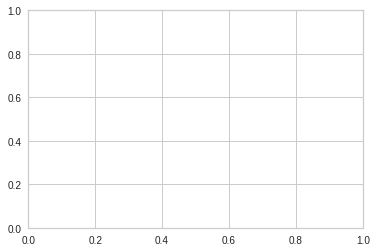

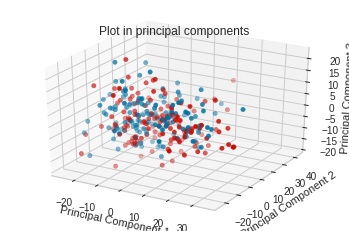

In [7]:
fig, ax = plt.subplots()

colors = np.array(['r' if yi else 'b' for yi in labels])
visualizer = PCADecomposition(scale=True, color=colors, proj_dim=3)
visualizer.fit_transform(data, labels)
visualizer.finalize()
visualizer.set_title('Plot in principal components')
plt.show()

## Feature ranking

/home/moeflon/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()
/home/moeflon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/home/moeflon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/moeflon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/home/moeflon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


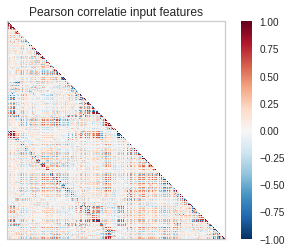

In [8]:
fig, ax = plt.subplots()

visualizer = Rank2D(features=data, algorithm='pearson', show_feature_names=False)
visualizer.fit(data, labels)   
visualizer.transform(data) 
visualizer.finalize()
visualizer.set_title('Pearson correlatie input features')
plt.show()

## Learning curve

/home/moeflon/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  0   2   5  21  24 268 271 419 420 421 422 423 439 442 458 461 470 477
 480 914 917 965 984] are constant.
  UserWarning)
/home/moeflon/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/moeflon/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  0   2   5  21  24 268 271 419 420 421 422 423 439 442 458 461 470 477
 480 914 917 965 984] are constant.
  UserWarning)
/home/moeflon/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/moeflon/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  0 

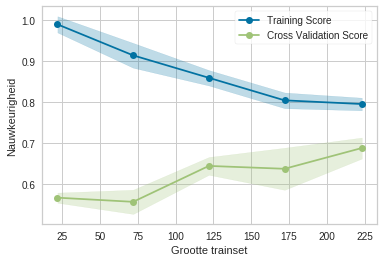

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)

kf = KFold(n_splits=4, shuffle=False)
visualizer = LearningCurve(best_pipe, scoring='accuracy', cv=kf, groups=ids, ax=ax)
visualizer.fit(data, labels)
visualizer.finalize()
visualizer.set_title('')
visualizer.ax.set_xlabel('Grootte trainset')
visualizer.ax.set_ylabel('Nauwkeurigheid');
plt.show()
fig.savefig('svm_leercurve.png', dpi=800)

## Cross-validation curves

<IPython.core.display.Javascript object>


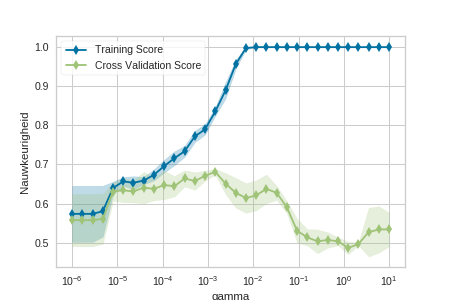

In [25]:
# Gamma
fig, ax = plt.subplots()
fig.set_size_inches(6,4)


gammas = np.logspace(-6, 1, 32).tolist()
kf = KFold(n_splits=4, shuffle=False)
visualizer = ValidationCurve(
    best_pipe, param_name="clf__gamma", param_range=gammas,
    logx=True, cv=kf, scoring="accuracy", n_jobs=-1
)
visualizer.fit(data, labels)
visualizer.finalize()
visualizer.set_title('')
visualizer.ax.set_xlabel('gamma')
visualizer.ax.set_ylabel('Nauwkeurigheid');
fig.savefig('svm_gamma.png', dpi=800)
plt.show()

<IPython.core.display.Javascript object>


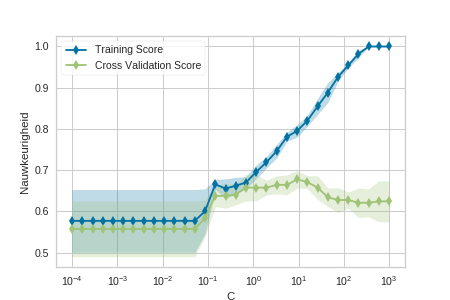

In [27]:
# C
fig, ax = plt.subplots()
fig.set_size_inches(6,4)

cs = np.logspace(-4, 3, 32)
kf = KFold(n_splits=4, shuffle=False)
visualizer = ValidationCurve(
    best_pipe, param_name="clf__C", param_range=cs,
    logx=True, cv=kf, scoring="accuracy", n_jobs=-1, ax=ax
)

visualizer.fit(data, labels)
visualizer.finalize()
visualizer.set_title('')
visualizer.ax.set_xlabel('C')
visualizer.ax.set_ylabel('Nauwkeurigheid');
fig.savefig('svm_C.png', dpi=800)

fig.show()

<IPython.core.display.Javascript object>


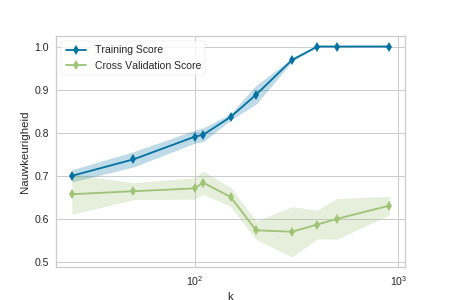

In [29]:
# k
fig, ax = plt.subplots()
fig.set_size_inches(6,4)


ks = [25, 50, 100, 110, 150, 200, 300, 400, 500, 900]
kf = KFold(n_splits=4, shuffle=False)
visualizer = ValidationCurve(
    best_pipe, param_name="selection__k", param_range=ks,
    logx=True, cv=kf, scoring="accuracy", n_jobs=-1, ax=ax
)

visualizer.fit(data, labels)
visualizer.finalize()
visualizer.set_title('')
visualizer.ax.set_xlabel('k')
visualizer.ax.set_ylabel('Nauwkeurigheid');
fig.savefig('svm_k.png', dpi=800)

fig.show()

<IPython.core.display.Javascript object>


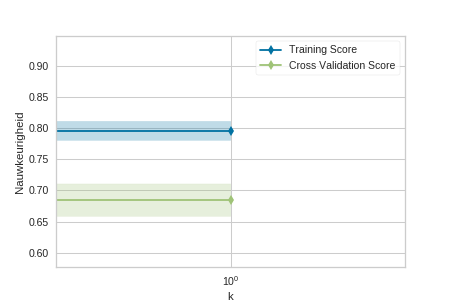

/home/moeflon/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  self.set_xlim(upper, lower, auto=None)


In [31]:
# k
fig, ax = plt.subplots()
fig.set_size_inches(6,4)


ks = [25, 50, 100, 110, 150, 200, 300, 400, 500, 900]
kf = KFold(n_splits=4, shuffle=False)
visualizer = ValidationCurve(
    best_pipe, param_name="clf__kernel", param_range=['linear', 'rbf'],
    logx=True, cv=kf, scoring="accuracy", n_jobs=-1, ax=ax
)

visualizer.fit(data, labels)
visualizer.finalize()
visualizer.set_title('')
visualizer.ax.set_xlabel('k')
visualizer.ax.set_ylabel('Nauwkeurigheid');
fig.savefig('svm_kernel.png', dpi=800)

fig.show()

## Precision-Recall

<IPython.core.display.Javascript object>


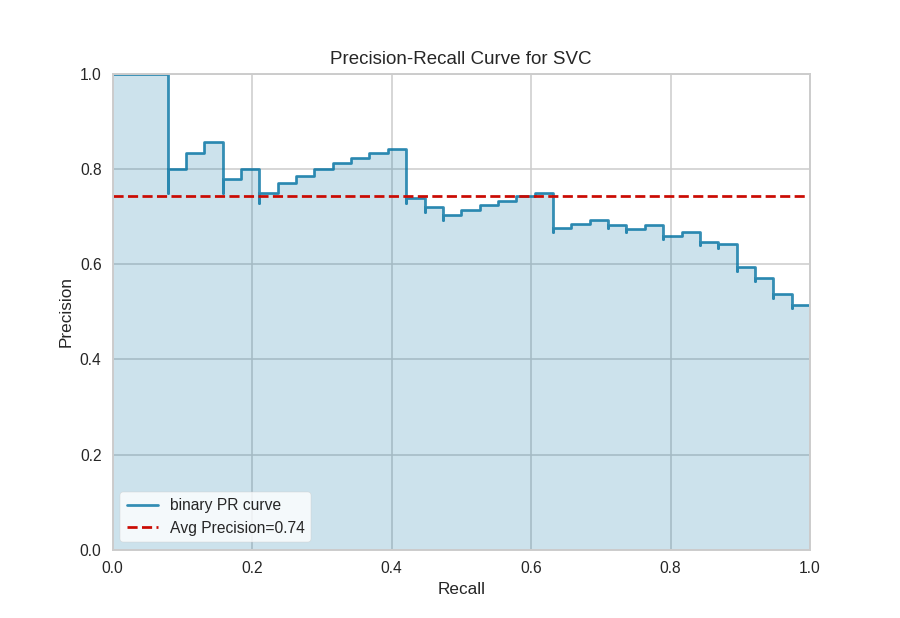

/home/moeflon/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  0   2   5  21  24 268 271 419 420 421 422 423 439 442 458 461 470 477
 480 914 917 965 984] are constant.
  UserWarning)
/home/moeflon/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [33]:
fig, ax = plt.subplots()

visualizer = PrecisionRecallCurve(best_pipe)
kf = KFold(n_splits=4, shuffle=False)
for fn, (train_index, test_index) in enumerate(kf.split(data)):
    train = data.iloc[train_index]
    y_train = labels[train_index]
    test = data.iloc[test_index]
    y_test = labels[test_index]
    
    visualizer.fit(train, y_train)
    break
    
visualizer.score(test, y_test)
visualizer.poof()